# Traffic Sign Recognition using CNN

In [1]:
import os
import zipfile
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

## Dataset

## 1. Dataset

> We are going to use the **German Traffic Sign Recognition Benchmark dataset**. The dataset contains over 50,000 traffic sign images belonging to 43 classes.

> The dataset is available to download at URL : https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html

In [2]:
#Fetch images deom GTSRB website
#Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  263M  100  263M    0     0  11.5M      0  0:00:22  0:00:22 --:--:-- 13.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0  9015k      0  0:00:09  0:00:09 --:--:-- 12.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99620  100 99620    0     0  51589      0  0:00:01  0:00:01 --:--:-- 51563


In [3]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
TESTING_DATA_DIR = "dataset/testing"

to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]

for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...


>GTSRB contains all the images in `.ppm` format. We need to convert them to tensorflow supported `.jpg` format.
  
> Let's convert the images and save them separately in training and testing directories.

In [4]:
# Collect all PPM files and their labels
tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir)
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f)
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)

# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)

    image.save(os.path.join(directory, image_filename))

#Load testing set
tmp_testing_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")
tmp_testing_data_files = [f for f in os.listdir(tmp_testing_data_dir) if f.endswith(".ppm")]
testing_images = []

#export as JPGs
for ppm_file in tmp_testing_data_files:
    image_dir = os.path.join(tmp_testing_data_dir, ppm_file)
    image = Image.open(image_dir)
    directory = TESTING_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)

    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    testing_images.append(final_image)
    testing_images.sort()

>Let's create a helper function for us to randomly visualize some images from our dataset and visualize some of our training and testing input data images and their shapes.

In [7]:
# Helper Function
def view_image(dir_path, class_name):
  """
    This function randomply visualizes images from a given directory and class
    name using matplotlib.pyplot module.
    Args:
      dir_path : Path of the parent directory
      class_name : Name of class the image belongs to
    Returns:
      the read image array
  """
  # Construct path to the image
  img_path = dir_path + "/" + class_name
  # Select a random image in the directory
  random_img = random.sample(os.listdir(img_path), 1)
  # Read the image
  img = np.asarray(Image.open(img_path + "/" + random_img[0]))
  # Plot the image
  plt.imshow(img)

  return img

(60, 59, 3)

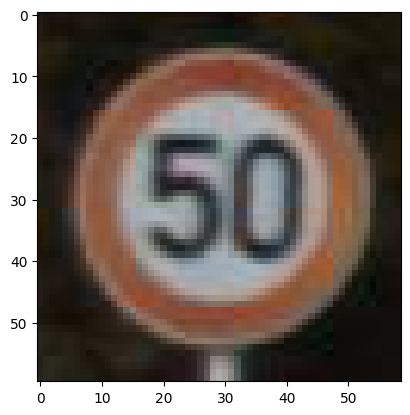

In [31]:
# Visualize training image
train_img = view_image(dir_path = TRAINING_DATA_DIR,
                 class_name = "00002")
train_img.shape

(133, 123, 3)

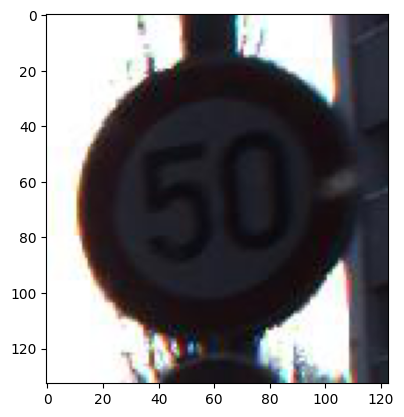

In [26]:
# Visualize testing image
test_img = view_image(dir_path = TESTING_DATA_DIR,
                      class_name = "")
test_img.shape

> Let's create a helper function to generate batches of data and create the training, validation and testing datasets.

In [32]:
# Create function to generate data
def get_data_iterator(data_dir,
                      batch_size=32,
                      image_size=(224, 224),
                      class_names=None,
                      label_mode='int'):
  """
    This function returns an iterable 'tf.data.Dataset' from the given data
    directory.
    Args:
      data_dir   : Directory where the image data is stored
      batch_size : Batch size to return in one iteration of the data
      image_size : Image size to be read
      class_name : Class names of the dataset
      label_mode : The label encoding mode
  """
  return image_dataset_from_directory(directory=data_dir,
                                      batch_size=batch_size,
                                      image_size=image_size,
                                      class_names=class_names,
                                      label_mode=label_mode)

In [34]:
# Create the training data
train_data = get_data_iterator(data_dir=TRAINING_DATA_DIR,
                               batch_size=32,
                               image_size=(32, 32),
                               label_mode='categorical')

Found 39209 files belonging to 43 classes.


In [35]:
# Create testing and validation data
tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=';')
val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

image_data_generator = ImageDataGenerator(validation_split=0.5)
test_data = image_data_generator.flow_from_dataframe(val_data_frame,
                                                     x_col='Filename',
                                                     directory=TESTING_DATA_DIR,
                                                     y_col='ClassId',
                                                     target_size=(32, 32),
                                                     subset='training')
valid_data = image_data_generator.flow_from_dataframe(val_data_frame,
                                                      x_col='Filename',
                                                      directory=TESTING_DATA_DIR,
                                                      y_col='ClassId',
                                                      target_size=(32, 32),
                                                      subset='validation')

Found 6315 validated image filenames belonging to 43 classes.
Found 6315 validated image filenames belonging to 43 classes.


<ipython-input-35-ecaf435f5c80>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg')


In [36]:
# Label map
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

## Model

> A deep learning model architecture consisting:

*   Normalization layer
*   Convolutional layer
*   MaxPooling layer
*   Dropout layer
*   Dense output layer

> Model compilation parameters:

*   Optimizer : Adam
*   Loss function : Categorical Cross Entropy
*   Evaluation Metric : Accuracy

> Model Training parameters:

*   Epochs : 50

In [37]:
# Create model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(43, activation='softmax')
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Fit the model
history = model.fit(train_data,
                epochs=50,
                steps_per_epoch=len(train_data),
                validation_data=valid_data,
                validation_steps=len(valid_data))

Epoch 1/50
1226/1226 [==============================] - 25s 12ms/step - loss: 1.5893 - accuracy: 0.5316 - val_loss: 0.5511 - val_accuracy: 0.8397
Epoch 2/50
1226/1226 [==============================] - 23s 19ms/step - loss: 0.3888 - accuracy: 0.8754 - val_loss: 0.3070 - val_accuracy: 0.9129
Epoch 3/50
1226/1226 [==============================] - 15s 12ms/step - loss: 0.2361 - accuracy: 0.9261 - val_loss: 0.2455 - val_accuracy: 0.9306
Epoch 4/50
1226/1226 [==============================] - 13s 11ms/step - loss: 0.1714 - accuracy: 0.9465 - val_loss: 0.2672 - val_accuracy: 0.9310
Epoch 5/50
1226/1226 [==============================] - 14s 11ms/step - loss: 0.1431 - accuracy: 0.9564 - val_loss: 0.2548 - val_accuracy: 0.9316
Epoch 6/50
1226/1226 [==============================] - 18s 14ms/step - loss: 0.1262 - accuracy: 0.9604 - val_loss: 0.2536 - val_accuracy: 0.9287
Epoch 7/50
1226/1226 [==============================] - 14s 11ms/step - loss: 0.1131 - accuracy: 0.9654 - val_loss: 0.2065 -

## Visualize the loss and accuracy curves

Text(0, 0.5, 'Accuracy')

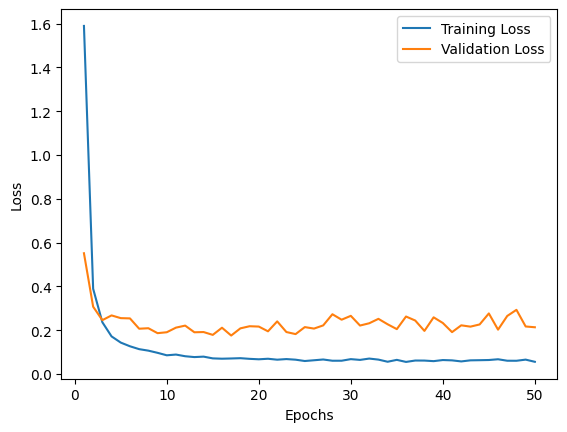

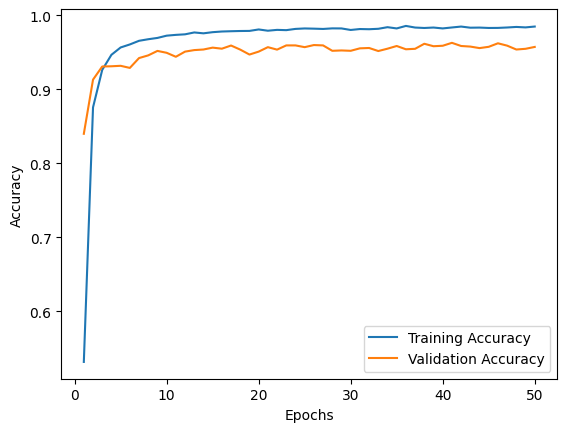

In [38]:
epochs = np.arange(1, 51, 1, dtype=int)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure()
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Testing Evaluation and Visualization

> We will evaluate our model on the test data with 2 steps.

1.   Using `model.evaluate()` method to get the test accuracy.
2.   By plotting images with their predictions for better visualization.


In [39]:
model.evaluate(test_data)

198/198 [==============================] - 3s 15ms/step - loss: 0.2493 - accuracy: 0.9539


[0.24926893413066864, 0.9539192318916321]

> As shown above, the model has a 95.39 % accuracy on the `Testing Dataset`.

> Let's create a helper function to plot test images and their predicted labels to visualize our mode's performance over a batch of test dataset.

In [62]:
# Helper function to visualize test predictions
def plot_predictions(model, X, y, label_map=label_map):
  """
    This function plots images with their predicted labels.
    Args:
      model     : The ML model
      X         : Image dataset
      y         : True labels
      label_map : The label map
  """
  # Make predictions
  y_pred = model.predict(X)

  # Create subplot sizes
  batch_size = len(X)
  num_plot_col = 8
  num_plot_row = batch_size // num_plot_col + (batch_size % num_plot_col > 0)

  # Plot the images and their labels
  plt.figure(figsize=(15, 9))
  plt.subplots_adjust(hspace=0.5)
  for i in range(batch_size):
    plt.subplot(num_plot_col, num_plot_row, i + 1)
    plt.imshow(X[i]/255)
    # Labels : 'green' if the prediction is correct, 'Red' otherwise
    color = 'green' if np.argmax(y[i]) == np.argmax(y_pred[i]) else 'red'
    plt.title(label_map[np.argmax(y_pred[i])].title(), color=color)
    plt.axis('off')

1/1 [==============================] - 0s 29ms/step


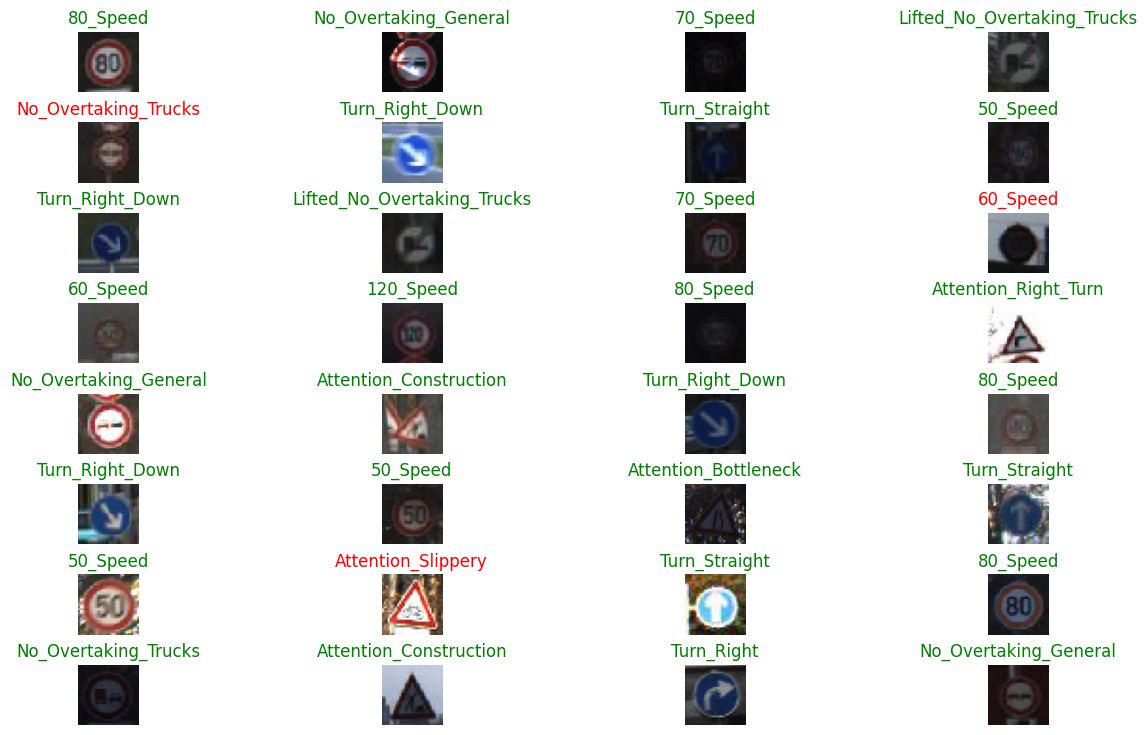

In [64]:
# Create the batch of data and visualize predictions
images, labels = test_data.next()
plot_predictions(model,
                 images,
                 labels,
                 label_map=label_map)